# [프로젝트] 청와대 청원으로 하는 한글 자연어 처리

- 참고자료: 파이썬으로 데이터 주무르기(민형기) 

교재의 프로젝트 대신 청와대 청원을 분석해보겠습니다. 데이터 범위는 '답변된 청원'으로만 한정할 것입니다.

먼저 [청와대 청원 홈페이지](https://www1.president.go.kr/petitions/answer)에서 모든 청원들을 가져와 데이터 프레임에 담고, 여러 카테고리 중 청원수가 많은 상위 1개의 카테고리를 선택해 청원 내용을 wordcloud로 시각화해보겠습니다. 또한 gensim을 활용해 Word2Vec으로 유사한 단어들도 함께 파악해보겠습니다! 

## 답변된 청원 웹크롤링 하기 

자, 코드를 짜기 전에 우선 어떤 식으로 프로젝트를 진행할지 생각해봅시다. 어떻게 하면 '답변된 청원'을 모두 가져올 수 있을까요? 여러 페이지에 걸쳐 있는 청원들을 어떻게 웹크롤링으로 가져올 수 있을까요? 이러한 사고 없이 코드만 먼저 보시게 되면 실질적인 문제 해결 역량은 성장하지 못할 수도...🌝 그러니 한번 어떻게 크롤링해올 것인가 고민해보시고, 이제까지 배운 크롤링들을 모두 활용하여 크롤링해봐야지! 라는 생각으로 최대한 고민하고 해보고 잘 안풀릴 때 코드를 보시면 더욱 더욱 큰 도움이 될 수 있을 것 같습니다.  참고로 아래 크롤링 코드는 비효율적이고 지저분할 수 있지만, 어쨌든 잘 가져와서 데이터 프레임에 담겨집니다.

**힌트:**
- urllib과 BeautifulSoup을 활용해 웹크롤링 
- 여러 페이지의 웹크롤링은 지난 스터디 '샌드위치 맛집 크롤링'을 활용

빈공간에 한번 생각해보시고 아래 코드를 보시면 더욱 도움이 됩니다! 따로 부연설명은 많이 적지 않았구요, 혼자 먼저 해보시고 잘 안되는 부분에서 고민을 하고 이 코드를 보시면 해결이 될 수 있을 것 같네요~🙃

In [2]:
# 한글 폰트 설정
# 까먹지 말고 런타임 다시 시작 해주시고 셀 실행 해주세요

import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [3]:
# 자연어 처리 모듈 설치
# 코드 실행 결과가 매우~~~ 깁니다.
!apt-get update 
!apt-get install g++ openjdk-8-jdk python-dev python3-dev 
!pip3 install JPype1-py3 
!pip3 install konlpy 
!JAVA_HOME="C:\Program Files\Java\jdk-13.0.2"

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:15 http

In [4]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd

In [5]:
titles = []
start_date = []
end_date = []
num_consent = []
answer_date = []
address = []

def get_info(url): 
    res = urlopen(url)
    soup = BeautifulSoup(res, "html.parser")
    
    # get titles, address(url)
    contents = soup.find_all('div', class_='ans_name_title')
    for n in range(0,len(contents)):
        content = contents[n]
        titles.append(content.a.get_text())
        add_url = str(content.find('a')['href'])
        address.append('https://www1.president.go.kr'+add_url)
    
    # 청원시작과 끝 날짜, 참여인원, 답변일 정보 얻기 
    infos = soup.find_all('ol', class_='ans_name_info')
    for info in infos: 
        start_date.append(info.find('p', class_='ans_list1_2').get_text()[2:-2])
        end_date.append(info.find('p', class_='ans_list2_2').get_text()[2:-2])
        num_consent.append(info.find('p', class_='ans_list3_2').get_text()[2:-2])
        answer_date.append(info.find('p', class_='ans_list4_2').get_text()[2:-2])          

In [6]:
for n in range(1,13): 
    url = 'https://www1.president.go.kr/petitions/answer?page=%d' % n
    get_info(url)

In [7]:
data = {'제목':titles, '청원시작일':start_date, '청원종료일': end_date,
       '참여인원': num_consent, '청원답변일':answer_date, 'URL':address}
df = pd.DataFrame(data)
df.head()

,제목,청원시작일,청원종료일,참여인원,청원답변일,URL
0,"판사, 검사 자녀들의 입시비리 전수조사를 해 주시기 바랍니다",2020. 12. 24,2021. 01. 23,"223,592",2021. 02. 19,https://www1.president.go.kr/petitions/594987
1,"정경심 1심 재판부(임정엽, 권성수, 김선희)의 탄핵을 요구합니다.",2020. 12. 24,2021. 01. 23,"459,416",2021. 02. 19,https://www1.president.go.kr/petitions/594995
2,"딸의 남자친구가 제 딸과, 언니인 제 큰 딸까지 살해하였습니다.",2020. 12. 23,2021. 01. 22,"260,545",2021. 02. 19,https://www1.president.go.kr/petitions/594944
3,잔인하고도 무서운 학교폭력으로 우리아들의 인생이 망가졌습니다.,2020. 12. 15,2021. 01. 14,"375,026",2021. 02. 10,https://www1.president.go.kr/petitions/594707
4,코로나전쟁에 왜 자영업자만 일방적 총알받이가 되나요? 대출원리금 임대료 같이 멈춰야...,2020. 12. 07,2021. 01. 06,"206,790",2021. 02. 02,https://www1.president.go.kr/petitions/594474


In [8]:
# 1차 저장 
df.to_csv('BlueHouse Petition data.csv', sep=',', encoding='utf-8')

여기까지 1차 저장을 해주었습니다. 각 청원 페이지에 들어가 세부 내용과 함께 청원 답변 등까지 모두 가져와 볼거에요.

In [9]:
# thousands는 왜 할까요? 
petition = pd.read_csv('BlueHouse Petition data.csv', thousands=',', encoding='utf-8', index_col=0)
petition.head()

,제목,청원시작일,청원종료일,참여인원,청원답변일,URL
0,"판사, 검사 자녀들의 입시비리 전수조사를 해 주시기 바랍니다",2020. 12. 24,2021. 01. 23,223592,2021. 02. 19,https://www1.president.go.kr/petitions/594987
1,"정경심 1심 재판부(임정엽, 권성수, 김선희)의 탄핵을 요구합니다.",2020. 12. 24,2021. 01. 23,459416,2021. 02. 19,https://www1.president.go.kr/petitions/594995
2,"딸의 남자친구가 제 딸과, 언니인 제 큰 딸까지 살해하였습니다.",2020. 12. 23,2021. 01. 22,260545,2021. 02. 19,https://www1.president.go.kr/petitions/594944
3,잔인하고도 무서운 학교폭력으로 우리아들의 인생이 망가졌습니다.,2020. 12. 15,2021. 01. 14,375026,2021. 02. 10,https://www1.president.go.kr/petitions/594707
4,코로나전쟁에 왜 자영업자만 일방적 총알받이가 되나요? 대출원리금 임대료 같이 멈춰야...,2020. 12. 07,2021. 01. 06,206790,2021. 02. 02,https://www1.president.go.kr/petitions/594474


In [10]:
len(petition)

181

의도한 청원 개수만큼 가져와졌습니다! 아래 코드는 대략 5-7분 정도 소요됩니다. 중간에 time.sleep()을 넣은 이유는 청와대 청원에서 웹크롤링(?) 매크로(?)를 막는 게 있는 것 같은데 시간을 주어서 헷갈리게(?) 하면 크롤링 됩니다.

In [11]:
import re 
import time
from tqdm import tqdm_notebook
from urllib.request import urlopen
from bs4 import BeautifulSoup

category =[]
content = []
answer = []
person = []

for n in tqdm_notebook(petition.index): 
    url = urlopen(petition['URL'][n]) 
    if n / 2 == 0:
        time.sleep(1)
    else: 
        time.sleep(2)
    soup = BeautifulSoup(url, "html.parser") 
    
    # get category 
    sector = soup.find('ul', class_='petitionsView_info_list')
    try: 
        category.append(sector.li.get_text()[4:])
    except AttributeError:
        print('AttributeError: index-', n, 'URL-', petition['URL'][n])
    person.append(sector.find_all('li')[3].get_text()[3:-6])


    # get petition content 
    content_raw = soup.find_all('div', class_='View_write')
    try: 
        if len(content_raw) > 1:
            content_raw_text = content_raw[1].get_text()
        else: 
            content_raw_text = content_raw[0].get_text()   
    except IndexError: 
        print('IndexError:', petition['URL'][n])
    
    content_split = re.split('\r|\t|\n|\xa0', content_raw_text)
    content.append(''.join(content_split))

    # get petition answer 
    answer_raw = soup.find_all('div', class_='pr_tk25')
    if len(answer_raw) > 1: 
        answer_raw_text = re.split("\r|\t|\n|\xa0", answer_raw[1].get_text())
    else: 
        answer_raw_text = re.split("\r|\t|\n|\xa0", answer_raw[0].get_text())
    answer_raw_text = ' '.join(answer_raw_text)
    answer.append(answer_raw_text[7:]) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


In [12]:
print(len(category), len(content), len(answer), len(person))

181 181 181 181


잘 출력되었습니다!

In [13]:
petition['카테고리'] = category
petition['청원내용'] = content
petition['청원답변'] = answer
petition['청원인'] = person

갯수만 봤을 때는 잘 가져온 것처럼 보여도, 이상한 데이터가 크롤링되는 경우도 있어요. 크롤링한 데이터를 저장해 파일로 열어본 후 전체를 쭉 확인해보는 것도 중요한 작업입니다 

In [16]:
petition[petition['청원내용'] == '']

,제목,청원시작일,청원종료일,참여인원,청원답변일,URL,카테고리,청원내용,청원답변,청원인


코드 실행결과 데이터가 모두 잘 크롤링 된 것 같습니다. 만약 잘못된 데이터가 있다면 제목 왼쪽의 숫자를 아래 코드에 입력해주세요. 없다면 아래의 코드는 생략하셔도 됩니다.

In [ ]:
for n in [147, 148, 149, 152]:  # 숫자는 예시입니다.
    url = urlopen(petition['URL'][n]) 
    soup = BeautifulSoup(url, "html.parser") 
    
    # get petition content 
    content_raw = soup.find_all('div', class_='View_write')
    content_raw_text = content_raw[2].get_text()
    content_split = re.split('\r|\t|\n|\xa0', content_raw_text)
    petition['청원내용'][n] = ''.join(content_split)
    
    # get petition answer 
    answer_raw = soup.find_all('div', class_='pr_tk25')
    answer_raw_text = re.split("\r|\t|\n|\xa0", answer_raw[2].get_text())
    answer_raw_text = ' '.join(answer_raw_text)
    petition['청원답변'][n] = answer_raw_text[7:]

In [18]:
# 이건 꼭 실행해주세요!
petition.to_csv('Final BlueHouse Petition data.csv', sep=',', encoding='utf-8')

여기까지가 데이터를 가져오는 과정이었습니다! 이 파일들은 다운로드를 해두시고 다음에 실행하실 때에는 파일을 드래그 하여 넣으신 다음에 쓰세요. 매번 크롤링해서 프로젝트를 진행하려면 시간이 너무 오래 걸립니다 ㅠ

## EDA(Exploratory Data Analysis) - 탐색적 자료 분석 

In [19]:
import pandas as pd
import platform
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [20]:
petition = pd.read_csv('Final BlueHouse Petition data.csv', 
                       index_col=0, parse_dates=['청원시작일','청원종료일','청원답변일'])
petition.head()

,제목,청원시작일,청원종료일,참여인원,청원답변일,URL,카테고리,청원내용,청원답변,청원인
0,"판사, 검사 자녀들의 입시비리 전수조사를 해 주시기 바랍니다",2020-12-24,2021-01-23,223592,2021-02-19,https://www1.president.go.kr/petitions/594987,정치개혁,입시제도를 위한 자녀들의 활동을 유죄로 판결하는 판사와 검사들의 자녀들은 과연 바르...,<판사 및 검사 자녀 입시비리 전수 조사> 국민청원에 답합니다. ...,kakao
1,"정경심 1심 재판부(임정엽, 권성수, 김선희)의 탄핵을 요구합니다.",2020-12-24,2021-01-23,459416,2021-02-19,https://www1.president.go.kr/petitions/594995,정치개혁,금일 청원은 청와대와 행정부가 직접적으로 행사할 권한이 아닌 국민을 대신하는 입법부...,<정경심 교수 1심 재판부 탄핵> 국민청원에 답합니다. 청원인께서...,facebook
2,"딸의 남자친구가 제 딸과, 언니인 제 큰 딸까지 살해하였습니다.",2020-12-23,2021-01-22,260545,2021-02-19,https://www1.president.go.kr/petitions/594944,기타,심신미약을 주장하는 범인이 제발 마땅한 벌을 받을 수 있도록 꼭 청원 동의 부탁드립...,<자매 살인사건 엄중처벌> 국민청원에 답합니다. 청원인께서는 20...,naver
3,잔인하고도 무서운 학교폭력으로 우리아들의 인생이 망가졌습니다.,2020-12-15,2021-01-14,375026,2021-02-10,https://www1.president.go.kr/petitions/594707,기타,저희 아들은 학교폭력으로 지금 의식이 없이 중환자실에 누워있습니다.저희아이는 **...,안녕하십니까. 디지털소통센터장 강정수입니다. 스파링을 가장해 학교...,naver
4,코로나전쟁에 왜 자영업자만 일방적 총알받이가 되나요? 대출원리금 임대료 같이 멈춰야...,2020-12-07,2021-01-06,206790,2021-02-02,https://www1.president.go.kr/petitions/594474,보건복지,코로나 규제방향을 올 한해동안 보고 있으면거의 90%이상 자영업자만 희생을 시키고 ...,안녕하십니까? 자영업비서관 인태연입니다. 코로나로 인한 자영업자의...,naver


In [21]:
petition.shape

(181, 10)

### 필요한 데이터만 남기기

분석에 필요한 데이터들만 남겨봅니다.

In [22]:
petition.drop(['URL', '청원종료일','청원답변','청원인'], axis=1, inplace=True)
petition.head()

,제목,청원시작일,참여인원,청원답변일,카테고리,청원내용
0,"판사, 검사 자녀들의 입시비리 전수조사를 해 주시기 바랍니다",2020-12-24,223592,2021-02-19,정치개혁,입시제도를 위한 자녀들의 활동을 유죄로 판결하는 판사와 검사들의 자녀들은 과연 바르...
1,"정경심 1심 재판부(임정엽, 권성수, 김선희)의 탄핵을 요구합니다.",2020-12-24,459416,2021-02-19,정치개혁,금일 청원은 청와대와 행정부가 직접적으로 행사할 권한이 아닌 국민을 대신하는 입법부...
2,"딸의 남자친구가 제 딸과, 언니인 제 큰 딸까지 살해하였습니다.",2020-12-23,260545,2021-02-19,기타,심신미약을 주장하는 범인이 제발 마땅한 벌을 받을 수 있도록 꼭 청원 동의 부탁드립...
3,잔인하고도 무서운 학교폭력으로 우리아들의 인생이 망가졌습니다.,2020-12-15,375026,2021-02-10,기타,저희 아들은 학교폭력으로 지금 의식이 없이 중환자실에 누워있습니다.저희아이는 **...
4,코로나전쟁에 왜 자영업자만 일방적 총알받이가 되나요? 대출원리금 임대료 같이 멈춰야...,2020-12-07,206790,2021-02-02,보건복지,코로나 규제방향을 올 한해동안 보고 있으면거의 90%이상 자영업자만 희생을 시키고 ...


### 카테고리별 청원수 


In [23]:
petition_cate = petition['카테고리'].value_counts()
petition_cate

인권/성평등         43
정치개혁           31
안전/환경          26
기타             23
육아/교육          14
보건복지           12
문화/예술/체육/언론    10
반려동물            7
교통/건축/국토        6
행정              4
일자리             2
외교/통일/국방        1
경제민주화           1
미래              1
Name: 카테고리, dtype: int64

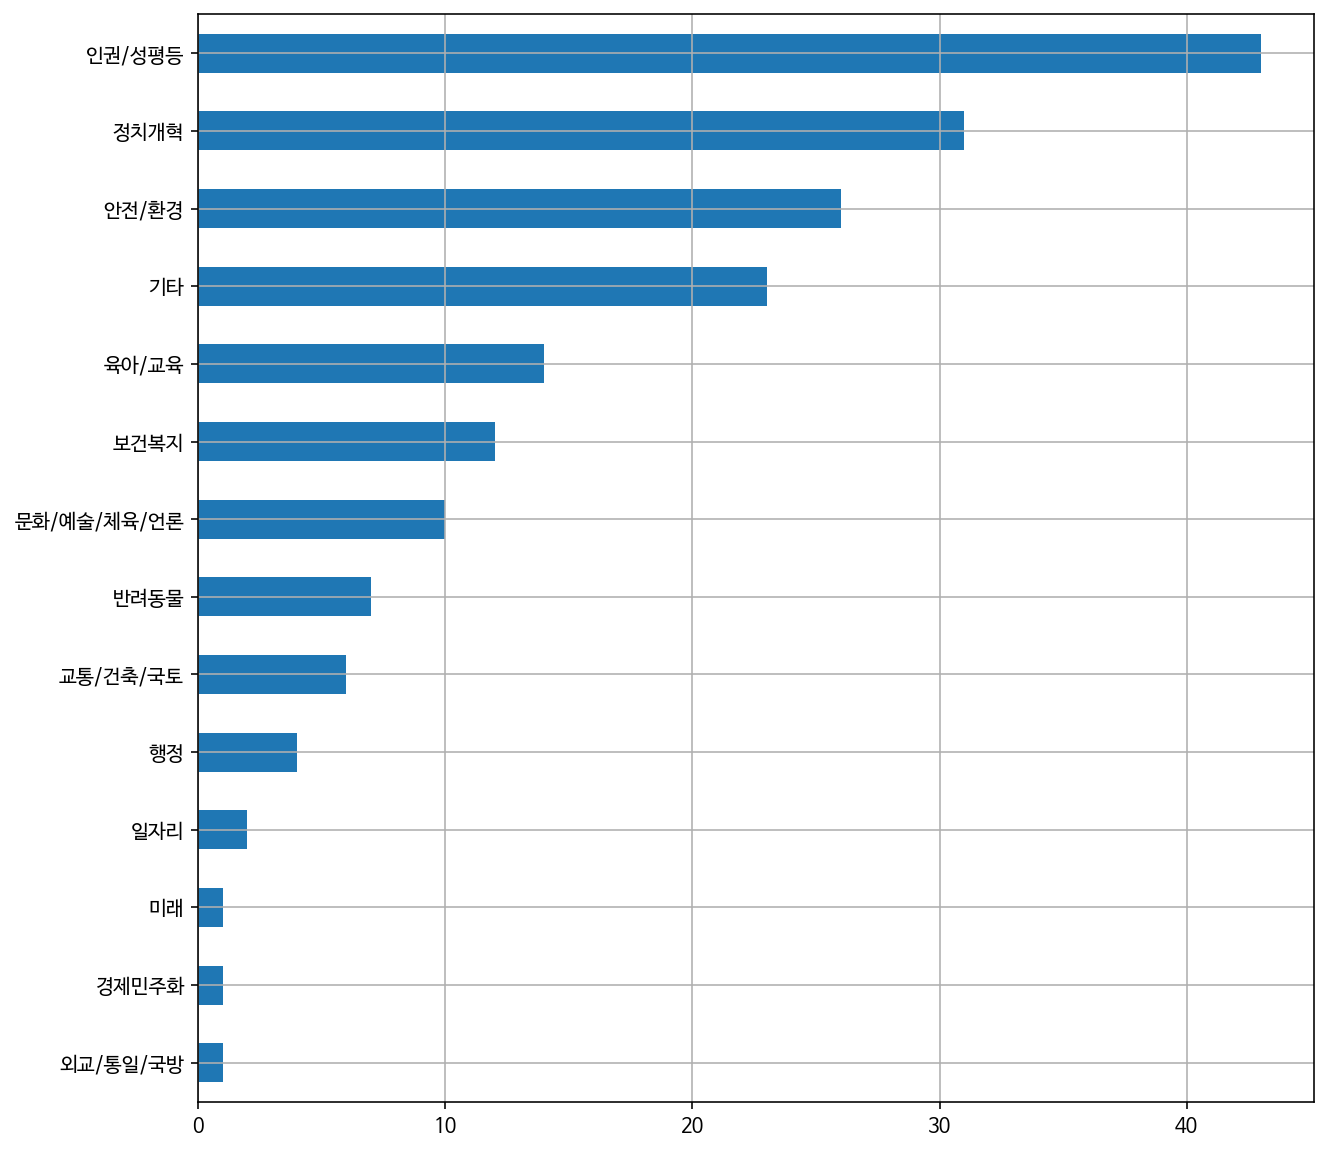

In [24]:
petition_cate.sort_values().plot(kind='barh', grid=True, figsize=(10,10))
plt.show()

인권/성평등 청원이 가장 많네요

### WordCloud로 시각화

저번 시간에 배운 자연어처리와 wordcloud를 활용해 시각화를 진행해보겠습니다. 청원 데이터 전부를 하기에는 너무 오래걸리니까, 가장 많은 청원 영역인 인권/성평등 분야만 골라 진행해볼게요

In [25]:
humanRights = petition[petition['카테고리'] == '인권/성평등']
humanRights.shape

(43, 6)

In [26]:
# 자연어처리 모듈 설치
!apt-get update 
!apt-get install g++ openjdk-8-jdk python-dev python3-dev 
!pip3 install JPype1-py3 
!pip3 install konlpy 
!JAVA_HOME="C:\Program Files\Java\jdk-13.0.2"

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 2s (116 kB/s

In [27]:
import nltk 
from konlpy.tag import Okt 
okt = Okt()

모든 청원내용을 하나의 변수 humanRights_text에다가 모두 넣어두겠습니다

In [28]:
humanRights_text = ''

for each_line in humanRights['청원내용']: 
  humanRights_text = humanRights_text + each_line + '\n'

# 형태소 단위로 쪼갠 token 만들기
tokens_ko = okt.morphs(humanRights_text)
tokens_ko

['1',
 '.',
 '10',
 '개',
 '월간',
 '잔인하게',
 '학대',
 '당하다',
 '처참하게',
 '죽은',
 '16',
 '개월',
 '입양아',
 '가해자',
 '부부',
 '의',
 '공식',
 '적',
 '인',
 '신',
 '상공',
 '개',
 '를',
 '요청',
 '합니다',
 '.',
 '이',
 '부부',
 '는',
 '최근',
 '공개',
 '된',
 '피',
 '씨방',
 '살인',
 '사건',
 '사건',
 '김',
 '*',
 '수',
 ',',
 '극악',
 '무도',
 '한',
 '시',
 '신',
 '훼손',
 '으로',
 '온',
 '국민',
 '을',
 '경악',
 '시킨',
 '고',
 '*',
 '정',
 '보다',
 '더',
 '하면',
 '더',
 '했지',
 '결코',
 '덜',
 '하지',
 '않습니다',
 '.',
 '상대',
 '는',
 '부모',
 '의',
 '보살핌이',
 '가장',
 '절실',
 '한',
 '고작',
 '7',
 '개월',
 '-',
 '16',
 '개월',
 '영',
 '유아',
 '였다는',
 '점',
 ',',
 '10',
 '개월',
 '의',
 '장기간',
 '에',
 '걸쳐',
 '24시간',
 '자행',
 '된',
 '잔인한',
 '학대',
 '수법',
 ',',
 '작은',
 '아기',
 '의',
 '몸',
 '에',
 '성',
 '한',
 '곳',
 '이',
 '없고',
 '내장',
 '기관',
 '이',
 '절단',
 '될',
 '정도',
 '로',
 '잔혹한',
 '살해',
 '방법',
 ',',
 '살해',
 '후',
 '죄책감',
 '없이',
 '태연하게',
 '한',
 '행동',
 ',',
 '끝',
 '까지',
 '반성',
 '없이',
 '혐의',
 '를',
 '부인',
 '하는',
 '태도',
 '등',
 '을',
 '고려',
 '할',
 '때',
 '전무후무',
 '하게',
 '극악',
 '무도',
 '합니다',
 '.',
 '온',
 '국민

token이 몇 개인지 봅시다

In [29]:
ko = nltk.Text(tokens_ko, name='인권/성평등 청원내용')
print(len(ko.tokens))
print(len(set(ko.tokens))) # 중복 제거 후! 

31391
5917


In [30]:
ko = nltk.Text(tokens_ko, name='청원내용')
ko.vocab().most_common(100)

[('.', 1008),
 ('을', 923),
 ('이', 733),
 ('의', 682),
 ('에', 534),
 ('를', 507),
 (',', 489),
 ('가', 411),
 ('은', 306),
 ('는', 287),
 ('들', 287),
 ('으로', 271),
 ('한', 245),
 ('피해자', 243),
 ('가해자', 232),
 ('것', 222),
 ('로', 170),
 ('입니다', 167),
 ('수', 165),
 ('사건', 164),
 ('과', 162),
 ('에서', 156),
 ('도', 149),
 ('하는', 138),
 ('와', 135),
 ('하고', 134),
 ('그', 129),
 ('적', 127),
 ('할', 124),
 ("'", 120),
 ('합니다', 117),
 ('제', 117),
 ('에게', 116),
 ('저', 114),
 ('(', 110),
 ('고', 104),
 ('인', 103),
 (')', 102),
 ('여성', 101),
 ('‘', 100),
 ('하여', 90),
 ('처벌', 90),
 ('’', 88),
 ('등', 85),
 ('까지', 79),
 ('딸', 77),
 ('?', 71),
 ('또한', 69),
 ('된', 68),
 ('수사', 67),
 ('1', 66),
 ('국민', 64),
 ('2', 63),
 ('못', 63),
 ('경찰', 63),
 ('다', 61),
 ('있습니다', 61),
 ('성', 58),
 ('사람', 56),
 ('진술', 56),
 ('증거', 55),
 ('범죄', 52),
 ('있는', 52),
 (':', 51),
 ('일', 50),
 ('생각', 50),
 ('위', 49),
 ('아동', 49),
 ('피해', 49),
 ('만', 49),
 ('안', 49),
 ('보호', 48),
 ('친구', 48),
 ('해', 48),
 ('말', 47),
 ('자신', 47),
 ('위해', 44)

불용어가 한가득이네요... 이제 한땀한땀 불용어를 제거해주도록 합시다

In [44]:
stop_words = ['.','을','이','의','를','에',',','가','들','은','는','으로','한','도',
              '수','에서','로','것','그','과','제','입니다','할','하고','적',"'",'하는',
              '합니다','와','에게','고','인',')','?','하여','등','저','있습니다','말','까지',
              '(','1','그리고','다','2','만','딸','했습니다','안','된','못','일','더','위',
              '있는','해','\n','또한','명','하지','..','정말','물','많은','"',
              '중','3','게','너무','A','자','이런','때','되지','위해','에는','없는',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘', '‘']

tokens_ko = [each_word for each_word in tokens_ko if each_word not in stop_words]

ko = nltk.Text(tokens_ko, name='인권/성평등 청원내용')
ko.vocab().most_common(50)

[('피해자', 243),
 ('가해자', 232),
 ('사건', 164),
 ('여성', 101),
 ('처벌', 90),
 ('’', 88),
 ('수사', 67),
 ('국민', 64),
 ('경찰', 63),
 ('성', 58),
 ('사람', 56),
 ('진술', 56),
 ('증거', 55),
 ('범죄', 52),
 (':', 51),
 ('생각', 50),
 ('아동', 49),
 ('피해', 49),
 ('보호', 48),
 ('친구', 48),
 ('자신', 47),
 ('성폭행', 44),
 ('->', 44),
 ('성범죄', 44),
 ('검사', 43),
 ('강간', 42),
 ('청원', 41),
 ('하였습니다', 41),
 ('행위', 38),
 ('분', 38),
 ('내용', 37),
 ('폭행', 37),
 ('법', 35),
 ('이유', 35),
 ('술', 35),
 ('서', 33),
 ('사실', 33),
 ('결과', 33),
 ('영상', 33),
 ('청소년', 33),
 ('부터', 32),
 ('중위', 32),
 ('님', 31),
 ('성폭력', 31),
 ('저희', 30),
 ('판결', 30),
 ('이상', 30),
 ('여자', 30),
 ('신랑', 29),
 ('신고', 28)]

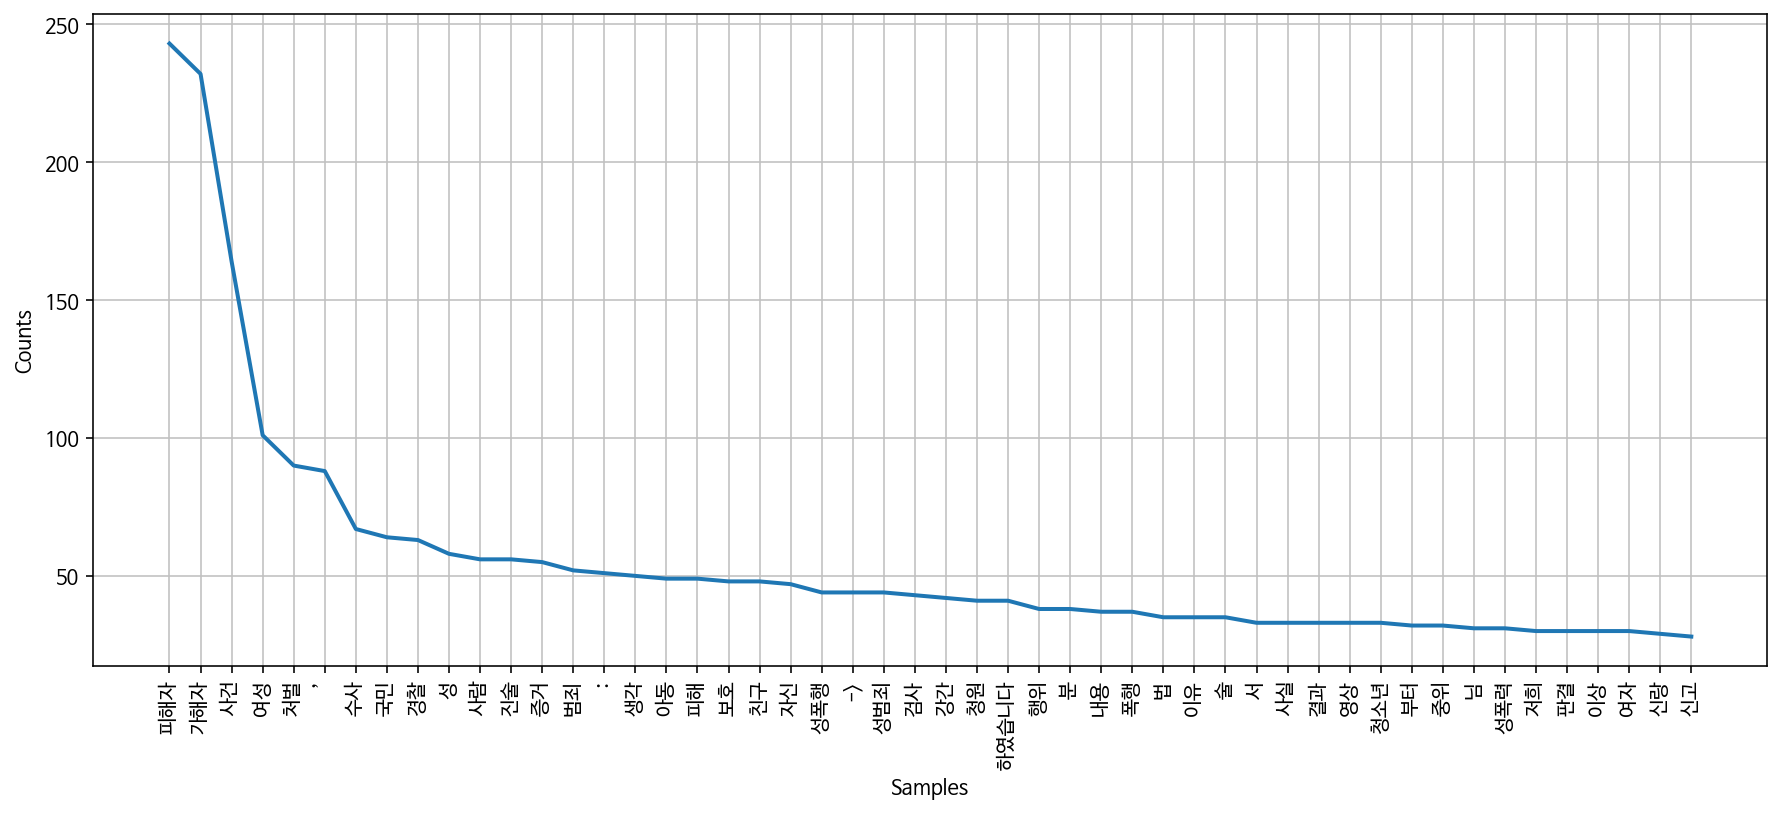

In [45]:
plt.figure(figsize=(15,6))
ko.plot(50)
plt.show()

'피해자', '가해자', '사건', '여성', '처벌' 순으로 Top 5 words가 나왔습니다.

In [46]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [47]:
data = dict(ko.vocab().most_common(150))

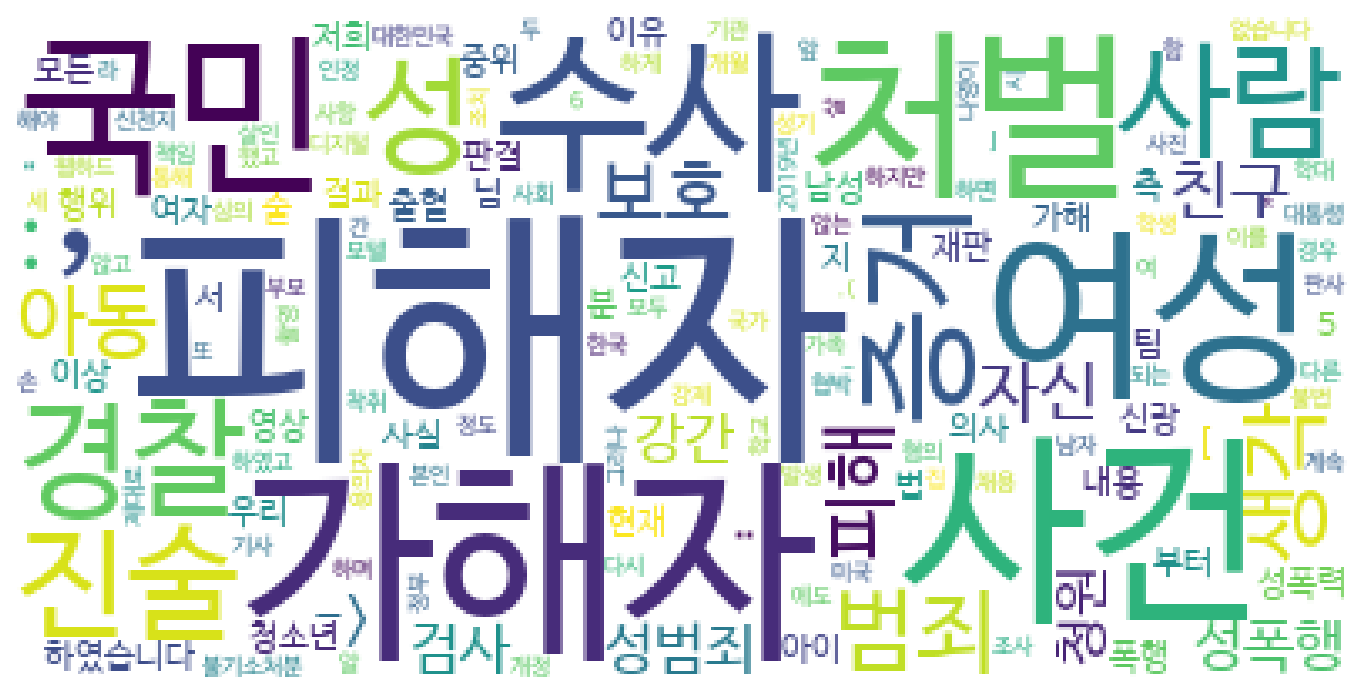

In [48]:
# for win : font_path='c:/Windows/Fonts/malgun.ttf'
# 나눔바른고딕 글씨체 있으면 가능, 없을 경우 font_path를 바꾸세요!
wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
                      relative_scaling = 0.2,
                      background_color='white',).generate_from_frequencies(data)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Word2Vec을 이용해 단어간 유사성 찾기 

 이런 것도 있구나~ 정도만 생각하고 넘어가지면 됩니다. word2vec이라는게 있는데 이것을 통해서 (맥락 포함한) 단어간 유사성을 볼 수 있겠구나 하구요. gensim이라는 모듈에서 word2vec을 제공하고 있습니다.


In [49]:
import gensim 
from gensim.models import word2vec

In [50]:
okt = Okt()
results = []

for line in humanRights['청원내용']: 
  # 형태소 분석 
  malist = okt.pos(line, norm=True, stem=True)
  # print(malist)
  r = []

  # word2vec 실행
  for word in malist: 
    if not word[1] in ['Josa', 'Eomi','punctuation']:
      r.append(word[0])

  r1 = (" ".join(r)).strip()
  results.append(r1)
  # print(r1)

In [51]:
data_file = 'human_rights.data'
with open(data_file, 'w', encoding='utf-8') as fp: 
  fp.write("\n".join(results))

만든 데이터 날라가지 않도록 우선 저장부터 해두고요! 

In [52]:
data = word2vec.LineSentence(data_file)
model = word2vec.Word2Vec(data, size=200, window=10, hs=1, min_count=2, sg=1)

model.save('human_rights.model')

In [53]:
model = word2vec.Word2Vec.load("human_rights.model")
# 1st 단어: 피해자
model.most_similar(positive=['피해자'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[('사진', 0.9150283932685852),
 ('협박', 0.9141892194747925),
 ('군', 0.9038378000259399),
 ('동영상', 0.8973603248596191),
 ('계속', 0.8948149681091309),
 ('찍다', 0.8926734328269958),
 ('대부분', 0.8920836448669434),
 ('성희롱', 0.8918523788452148),
 ('하다', 0.8872294425964355),
 ('태도', 0.8833484053611755)]

피해자와 긍정적으로 연관된 단어들입니다. 어떤 의미에서 긍정적인걸까요?

In [54]:
# 2nd 단어: 가해자
model.most_similar(positive=['가해자'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('후배', 0.9411976933479309),
 ('자신', 0.9370536208152771),
 ('먹이다', 0.9356449246406555),
 ('마시다', 0.9276288151741028),
 ('방치', 0.9196041822433472),
 ('말다', 0.9166461229324341),
 ('찍다', 0.9161152243614197),
 ('사망', 0.9123244285583496),
 ('게임', 0.9117426872253418),
 ('부르다', 0.9114404916763306)]

가해자와 긍정적으로 연관된 단어들입니다. 피해자하고 확연히 차이가 나네요.

In [55]:
model.most_similar(positive=['여성', '성범죄'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('화장실', 0.9136096239089966),
 ('남성', 0.8988600969314575),
 ('그중', 0.8833297491073608),
 ('저지르다', 0.8829664587974548),
 ('기회', 0.8800559043884277),
 ('디지털', 0.8772540092468262),
 ('동시', 0.8739908933639526),
 ('크다', 0.8736681342124939),
 ('Target', 0.8703141808509827),
 ('세계', 0.8680324554443359)]

여성과 성범죄 두 단어와 함께 관련된 단어들의 리스트입니다. 여러가지가 나오네요. 

## 과제

여기서 끝내긴 너무 아쉬우니 과제가 나갑니다. 원망의 소리가 들리는 건 착각이겠죠? ㅎㅎ EDA 중심으로 한번 배워본 것들을 복습해봅시다. 

- 과제1:
참여인원순 Top10 카테고리를 정렬하여 데이터프레임으로 나타내고, 이를 잘 나타낼 수 있는 표를 사용해 시각화 해주세요. 

- 과제2: 
petition의 청원시작일 칼럼은 청원이 게시된 날짜, 청원답변일은 청원이 답변된 날짜를 의미합니다. 이를 활용해 1) 청원 게시일부터 청원이 답변된 날짜까지의 평균을 구하고, 2) 카테고리별 평균 청원답변일수를 구하여 데이터프레임으로 나타내세요. 

- 과제3: 
카테고리 정치개혁의 청원내용을 wordcloud로 시각화하세요.

## 공부를 끝내며 

드디어 대망의 한글 자연어 처리 기초가 마무리되었습니다. 더불어 데분 스터디도 마무리되고요. 열심히 공부한 당신, 수고하셨습니다👏👏👏

완벽하게 모든 코드를 섭렵하고 이해하고 그러지는 못했을 겁니다. 그게 당연한거에요. 실제 엔지니어들도 모든 코드들을 다 외워서 쓰지 않습니다. 뻥인 것 같다고요? 아니에요! 진짜 엔지니어들도 매일매일 구글링 해가면서 코딩합니다. 중요한 것은 이러한 분석기법이, 코딩기법이 있다는 것을 아는 것입니다.👩‍💻

데이터분석 입문 스터디의 궁극적인 목표는 '기술적 상상력💻'을 길러주는 것입니다. 어떤 문제상황을 기술로서 해결할 수 있다는 가능성을 보여주는게 스터디의 가장 큰 목적입니다. 계속 까먹고, 잘 못하고 그런게 무슨 상관이 있나요. 예전에는 이런 방식으로 분석하는 것이 여러분들의 선택지에 없었다면, 이제는 잘 못하더라도 이렇게 해석하고 분석할 수 있다는 선택지의 방향이 생겼다는 사실에 의미를 둡시다. 자, 이제 자신이 정말 대단해보이지 않나요?

다음주부터는 COCO(Cosadama Conference) 준비를 시작합니다. 여태까지 배운 지식들을 실제 데이터에 적용해 여러분들이 직접!!! 분석을 해볼 거예요. 어떠한 주제를, 어떠한 데이터를 갖고 분석해볼지 고민해보면 좋을 것 같습니다.

두근두근💕 설렘을 가득 안고 COCO도 화이팅~